In [580]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [2]:
df = pd.read_csv('deltaRE_og_description.csv')

In [3]:
df.columns

Index(['half_inning', 'Unnamed: 1', 'pitch_type', 'game_date', 'release_speed',
       'release_pos_x', 'release_pos_z', 'player_name', 'batter', 'pitcher',
       ...
       'total_runs', 'half_inning.1', 'max_runs_in_half_inning', 'roi_score',
       'count_state', 'state', 'runner_state', 'RE', 'next_runs', 'deltaRE'],
      dtype='object', length=104)

In [369]:
model_data = df.loc[(df['description'] == 'called_strike') | (df['description'] == 'ball')].copy() # only called strikes and balls

In [370]:
model_data['is_strike'] = model_data['description'].map({'called_strike': 1, 'ball': 0}) # convert to binary
model_data['p_throws'] = model_data['p_throws'].map({'R': 1, 'L': 0}) # convert to binary
model_data['stand'] = model_data['stand'].map({'R': 1, 'L': 0}) # convert to binary

In [371]:
model_data.dropna(subset=['release_extension', 'spin_axis'], inplace=True)

In [372]:
#map pitch types to numbers
pitch_type_dict = {'FF': 1, 'SL': 2, 'CH': 2, 'CU': 2, 'SI': 1, 'FC': 1, 'KC': 2, 'FS': 2, 'KN': 2, 'EP': 2, 'FO': 2, 'SC': 2, 'ST': 2, 'FA': 1, 'SV': 2, 'CS': 2, 'nan': 17}
model_data['pitch_type_dict'] = model_data['pitch_type'].map(pitch_type_dict)

In [373]:
model_data.loc[model_data['p_throws'] == 'L', 'pfx_x'] *= -1

In [744]:
fastball_data = model_data[model_data['pitch_type_dict'] == 1]
avg_values = fastball_data.groupby('pitcher').agg({
    'release_speed': 'mean',
    'pfx_x': 'mean',
    'pfx_z': 'mean'
}).reset_index()
avg_values.columns = ['pitcher', 'avg_velo', 'avg_hmov', 'avg_vmov']

In [745]:
model_data = pd.merge(model_data, avg_values, on='pitcher', how='left')

In [746]:
model_data['velo_diff'] = model_data['release_speed'] - model_data['avg_velo']
model_data['hmov_diff'] = model_data['pfx_x'] - model_data['avg_hmov']
model_data['vmov_diff'] = model_data['pfx_z'] - model_data['avg_vmov']


In [747]:
model_data['likely_strike'] = ((model_data['plate_x'].abs() <= .708) & 
                               (model_data['plate_z'] <= model_data['sz_top']) & 
                               (model_data['plate_z'] >= model_data['sz_bot'])).astype(int)


In [748]:
fastball_data = model_data[model_data['pitch_type_dict'] == 1].copy()
offspeed_data = model_data[model_data['pitch_type_dict'] == 2].copy()

In [749]:
fastball_data.head()

,half_inning,Unnamed: 1,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,...,deltaRE,is_strike,pitch_type_dict,velo_diff,hmov_diff,vmov_diff,likely_strike,avg_velo,avg_hmov,avg_vmov
0,716352_1_Bot,11,SI,2023-10-01,92.0,-2.78,5.68,"King, Michael",672580,650633,...,-0.038179,1,1,-2.302347,-0.206931,-0.295325,1,94.302347,-1.063069,0.785325
1,716352_1_Bot,8,SI,2023-10-01,93.5,-2.60,5.68,"King, Michael",677951,650633,...,-0.028510,1,1,-0.802347,-0.186931,-0.135325,0,94.302347,-1.063069,0.785325
2,716352_1_Bot,7,SI,2023-10-01,94.0,-2.59,5.74,"King, Michael",677951,650633,...,0.020254,0,1,-0.302347,-0.056931,0.104675,0,94.302347,-1.063069,0.785325
4,716352_1_Bot,3,SI,2023-10-01,93.9,-2.62,5.54,"King, Michael",521692,650633,...,-0.016909,1,1,-0.402347,-0.146931,-0.165325,1,94.302347,-1.063069,0.785325
5,716352_1_Bot,2,FF,2023-10-01,95.8,-2.24,5.97,"King, Michael",521692,650633,...,-0.017354,1,1,1.497653,0.763069,0.194675,1,94.302347,-1.063069,0.785325


In [750]:
offspeed_data.head()

,half_inning,Unnamed: 1,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,...,deltaRE,is_strike,pitch_type_dict,velo_diff,hmov_diff,vmov_diff,likely_strike,avg_velo,avg_hmov,avg_vmov
3,716352_1_Bot,5,ST,2023-10-01,81.9,-2.67,5.47,"King, Michael",677951,650633,...,0.038821,0,2,-12.402347,2.503069,-0.745325,0,94.302347,-1.063069,0.785325
11,716352_1_Top,19,CU,2023-10-01,70.3,-1.17,6.16,"Greinke, Zack",683011,425844,...,0.046788,0,2,-18.803535,1.348232,-1.857795,0,89.103535,-0.488232,1.037795
12,716352_1_Top,14,SL,2023-10-01,78.9,-1.41,6.10,"Greinke, Zack",643396,425844,...,-0.076965,1,2,-10.203535,1.798232,-1.317795,1,89.103535,-0.488232,1.037795
21,716352_2_Top,52,CU,2023-10-01,70.3,-1.30,6.18,"Greinke, Zack",665828,425844,...,0.032970,0,2,-18.803535,1.288232,-1.897795,0,89.103535,-0.488232,1.037795
22,716352_2_Top,51,SL,2023-10-01,76.8,-1.38,6.19,"Greinke, Zack",665828,425844,...,0.068803,0,2,-12.303535,1.878232,-1.077795,0,89.103535,-0.488232,1.037795


# Fastball Model First

In [808]:
x = fastball_data.drop(['description', 'half_inning', 'events', 'state', 'game_pk', 'game_date', 'count_state', 'des', 'pitch_type_dict',
                     'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 'game_type', 'home_team', 'zone',
                     'away_team', 'type', 'bb_type', 'inning_topbot', 'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated',
                     'hit_distance_sc', 'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle',
                     'woba_value', 'woba_denom', 'babip_value', 'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score',
                     'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 'post_fld_score',
                      'if_fielding_alignment', 'of_fielding_alignment', 'delta_home_win_exp', 'delta_run_exp', 'total_runs', 'max_runs_in_half_inning', 'next_runs', 'runner_state', 'half_inning.1', 'player_name', 'hit_location', 'umpire', 'sv_id', 'spin_dir', 'roi_score', 'Unnamed: 1',
                      'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 
                      'fielder_9', 'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 'RE','pitch_number',  'at_bat_number', 'inning', 'stand',
                      #removed these columns because of collinearity
                      'release_speed', 'release_pos_z',  'effective_speed', 'release_pos_y', 'vy0', 'vx0', 'ax', 'release_extension', 'spin_axis', 'release_spin_rate',
                      'pfx_z', 'ay', 'p_throws', 'az', 'avg_velo', 'avg_hmov', 'avg_vmov',
                      #'release_spin_rate', 'p_throws', 'spin_axis', 'zone',
                      #removed these columns because they are not useful
                      'hmov_diff', 'vmov_diff', 'vz0', 'pfx_x', 'release_pos_x', 'velo_diff'
                      ], axis=1).copy()

In [809]:
x = x.dropna()

In [810]:
x1 = x.drop(['is_strike'], axis=1).copy()
y1 = x['is_strike'].copy()

In [811]:
vif_data = pd.DataFrame()
vif_data["feature"] = x1.columns

# Calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(x1.values, i) for i in range(len(x1.columns))]

print(vif_data)

         feature         VIF
0          balls    1.921064
1        strikes    1.999438
2        plate_x    1.025413
3        plate_z    8.138758
4      fielder_2   87.111500
5         sz_top  601.170462
6         sz_bot  508.049015
7        deltaRE    1.310620
8  likely_strike    1.775348


In [830]:
x_train, x_test, y_train, y_test = train_test_split(x1, y1, test_size=0.2, random_state=42) # split data

In [831]:
# Extracting 'fielder_2' and 'deltaRE' into separate DataFrames
x_train_catchers = x_train[['fielder_2', 'deltaRE', 'plate_x', 'plate_z', 'sz_top', 'sz_bot']].copy()
x_test_catchers = x_test[['fielder_2', 'deltaRE', 'plate_x', 'sz_top', 'plate_z', 'sz_bot']].copy()

# Dropping 'fielder_2' and 'deltaRE' columns from the original DataFrames
x_train.drop(['fielder_2', 'deltaRE', 'plate_x', 'sz_top', 'sz_bot'], axis=1, inplace=True)
x_test.drop(['fielder_2', 'deltaRE', 'plate_x', 'sz_top', 'sz_bot'], axis=1, inplace=True)

In [832]:
scaler = StandardScaler() # scale data
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [833]:
clf = LogisticRegression(random_state=0).fit(x_train_scaled, y_train)

In [834]:
# Get feature importance (coefficients)
feature_importance = clf.coef_[0]

In [835]:
# Pair feature names with their importance
features = list(x_train.columns)
feature_importance_dict = dict(zip(features, feature_importance))

In [836]:
sorted_features = {k: v for k, v in sorted(feature_importance_dict.items(), key=lambda item: abs(item[1]), reverse=True)}

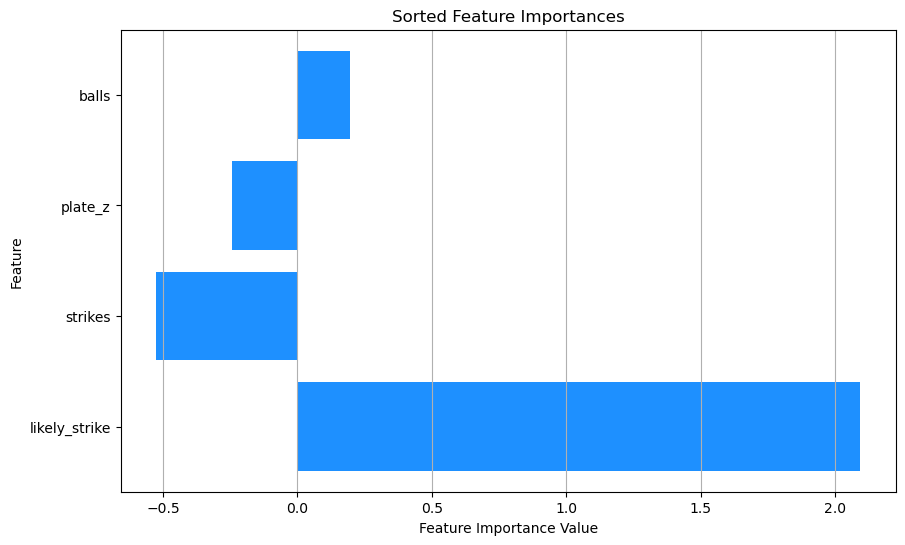

In [837]:
# Convert the dictionary to a DataFrame
df_sorted_features = pd.DataFrame(list(sorted_features.items()), columns=['Feature', 'Importance'])

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.barh(df_sorted_features['Feature'], df_sorted_features['Importance'], color='dodgerblue')
plt.xlabel('Feature Importance Value')
plt.ylabel('Feature')
plt.title('Sorted Feature Importances')
plt.grid(axis='x')

# Show the plot
plt.show()

In [838]:
# Predict 'is_strike' on the test set
y_pred = clf.predict(x_test_scaled)

y_pred

array([1, 0, 0, ..., 1, 0, 0], dtype=int64)

In [839]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)


In [840]:
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1:', f1)
print('Confusion Matrix:\n', conf_matrix)

Accuracy: 0.8833406018316616
Precision: 0.9521190261496844
Recall: 0.7113791012598532
F1: 0.8143292330235606
Confusion Matrix:
 [[25900   531]
 [ 4284 10559]]


In [841]:
x_test_catchers.head()

,fielder_2,deltaRE,plate_x,sz_top,plate_z,sz_bot
105696,455117,-0.028510,-0.29,3.22,2.92,1.61
84099,645444,0.071328,1.56,3.39,1.48,1.60
133770,663728,-0.075513,0.87,3.23,2.32,1.63
14387,681807,0.153931,0.23,3.37,3.77,1.59
278027,669127,0.001100,0.09,3.10,4.11,1.52


In [842]:

result_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
result_df.reset_index(drop=True, inplace=True)
x_test_catchers.reset_index(drop=True, inplace=True)
result_df = pd.concat([result_df, x_test_catchers.reset_index(drop=True)], axis=1)

In [843]:
result_df.head()

,Actual,Predicted,fielder_2,deltaRE,plate_x,sz_top,plate_z,sz_bot
0,1,1,455117,-0.028510,-0.29,3.22,2.92,1.61
1,0,0,645444,0.071328,1.56,3.39,1.48,1.60
2,1,0,663728,-0.075513,0.87,3.23,2.32,1.63
3,0,0,681807,0.153931,0.23,3.37,3.77,1.59
4,0,0,669127,0.001100,0.09,3.10,4.11,1.52


In [866]:
# Mask for false negatives
mask_false_negatives = (result_df['Actual'] == 1) & (result_df['Predicted'] == 0)

# Mask for false positives
mask_false_positives = (result_df['Actual'] == 0) & (result_df['Predicted'] == 1)

# Filter the DataFrame for false negatives and false positives
false_negatives_df = result_df[mask_false_negatives]
false_positives_df = result_df[mask_false_positives]

# Concatenate the two to create a DataFrame containing both
framing = pd.concat([false_negatives_df, false_positives_df])

In [867]:
len(framing)

4815

In [868]:
# Create a boolean mask for the conditions
condition_mask = (
    (framing['plate_x'].abs() <= .708) & 
    (framing['plate_z'] <= framing['sz_top']) & 
    (framing['plate_z'] >= framing['sz_bot'])
)

# Assign 1 or 0 to 'true_strike' based on the conditions
framing['true_strike'] = 0  # Initialize all as 0
framing.loc[condition_mask, 'true_strike'] = 1  # Set to 1 where conditions are met
framing.loc[framing['true_strike'] == 0, 'sum_of_squares'] = ((framing['plate_x']**2 + framing['plate_z']**2)**.5)
framing['normalized_sum_of_squares'] = (framing['sum_of_squares'] - framing['sum_of_squares'].min()) / (framing['sum_of_squares'].max() - framing['sum_of_squares'].min())
framing['framing_runs'] = framing['deltaRE'] - framing['normalized_sum_of_squares']

In [869]:
players = pd.read_csv('player_query.csv')
merged = framing.merge(players, left_on='fielder_2', right_on='mlb_id', how='left')

In [870]:
merged.groupby('mlb_name')['framing_runs'].sum().sort_values(ascending=False)

mlb_name
Meibrys Viloria      -0.280519
Michael Perez        -0.817886
Zack Collins         -0.844578
Tres Barrera         -0.879204
Manny Pina           -0.920845
                       ...    
Francisco Alvarez   -56.629909
Keibert Ruiz        -57.953246
William Contreras   -61.093413
Cal Raleigh         -64.275413
Jonah Heim          -69.253425
Name: framing_runs, Length: 98, dtype: float64

In [721]:
# Group by 'catcher' and sum 'deltaRE', then filter those with count above 25
leaderboard = merged.groupby('mlb_name').agg({'deltaRE': 'sum', 'mlb_name': 'count'})
leaderboard.columns = ['Total_deltaRE', 'Count']
leaderboard_filtered = leaderboard.sort_values(by='Total_deltaRE', ascending=False)

leaderboard_filtered.to_csv('leaderboard_fb.csv')

# Off-speed Model

In [1051]:
off = offspeed_data.drop(['description', 'half_inning', 'events', 'state', 'game_pk', 'game_date', 'count_state', 'des', 'pitch_type_dict', 'zone',
                     'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 'game_type', 'home_team', 'avg_velo', 'avg_hmov', 'avg_vmov',
                     'away_team', 'type', 'bb_type', 'inning_topbot', 'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated',
                     'hit_distance_sc', 'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle',
                     'woba_value', 'woba_denom', 'babip_value', 'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score',
                     'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 'post_fld_score',
                      'if_fielding_alignment', 'of_fielding_alignment', 'delta_home_win_exp', 'delta_run_exp', 'total_runs', 'max_runs_in_half_inning', 'next_runs',
                      'runner_state', 'half_inning.1', 'player_name', 'hit_location', 'umpire', 'sv_id', 'spin_dir', 'roi_score', 'Unnamed: 1',
                      'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 
                      'fielder_9', 'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 'RE','pitch_number',  'at_bat_number', 'inning', 'stand',
                      #removed these columns because of collinearity
                      'release_speed', 'effective_speed', 'release_pos_y', 'az', 'vy0', 'vx0', 'release_pos_z',  'release_extension', 'ay', 'p_throws', 'release_spin_rate', 
                      'vmov_diff', 'hmov_diff', 'spin_axis',
                      # 'sz_bot', 'ax', 'ay', 'az',
                      #'release_spin_rate', 'p_throws', 'spin_axis', 'zone',
                      #removed these columns because they are not useful
                      'pfx_x', 'pfx_z', 'release_pos_x', 'velo_diff'
                      ], axis=1).copy()

In [1052]:
s = off.dropna()

In [1059]:
offspeed_data.head()

,half_inning,Unnamed: 1,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,...,deltaRE,is_strike,pitch_type_dict,velo_diff,hmov_diff,vmov_diff,likely_strike,avg_velo,avg_hmov,avg_vmov
3,716352_1_Bot,5,ST,2023-10-01,81.9,-2.67,5.47,"King, Michael",677951,650633,...,0.038821,0,2,-12.402347,2.503069,-0.745325,0,94.302347,-1.063069,0.785325
11,716352_1_Top,19,CU,2023-10-01,70.3,-1.17,6.16,"Greinke, Zack",683011,425844,...,0.046788,0,2,-18.803535,1.348232,-1.857795,0,89.103535,-0.488232,1.037795
12,716352_1_Top,14,SL,2023-10-01,78.9,-1.41,6.10,"Greinke, Zack",643396,425844,...,-0.076965,1,2,-10.203535,1.798232,-1.317795,1,89.103535,-0.488232,1.037795
21,716352_2_Top,52,CU,2023-10-01,70.3,-1.30,6.18,"Greinke, Zack",665828,425844,...,0.032970,0,2,-18.803535,1.288232,-1.897795,0,89.103535,-0.488232,1.037795
22,716352_2_Top,51,SL,2023-10-01,76.8,-1.38,6.19,"Greinke, Zack",665828,425844,...,0.068803,0,2,-12.303535,1.878232,-1.077795,0,89.103535,-0.488232,1.037795


In [1068]:
x2 = s.drop(['is_strike'], axis=1).copy()
y2 = s['is_strike'].copy()

In [1069]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(x2, y2, test_size=0.2, random_state=42) # split data

In [1070]:
# Extracting 'fielder_2' and 'deltaRE' into separate DataFrames
x_train_catchers1 = x_train1[['fielder_2', 'deltaRE', 'plate_x', 'plate_z', 'sz_top', 'sz_bot']].copy()
x_test_catchers1 = x_test1[['fielder_2', 'deltaRE', 'plate_x', 'sz_top', 'plate_z', 'sz_bot']].copy()

# Dropping 'fielder_2' and 'deltaRE' columns from the original DataFrames
x_train1.drop(['fielder_2', 'deltaRE', 'plate_x', 'sz_top', 'sz_bot'], axis=1, inplace=True)
x_test1.drop(['fielder_2', 'deltaRE', 'plate_x', 'sz_top', 'sz_bot'], axis=1, inplace=True)

In [1071]:
vif_data1 = pd.DataFrame()
vif_data1["feature"] = x_train1.columns

# Calculating VIF for each feature
vif_data1["VIF"] = [variance_inflation_factor(x_train1.values, i) for i in range(len(x_train1.columns))]
print(vif_data1)

         feature       VIF
0          balls  1.934875
1        strikes  2.368333
2        plate_z  2.021801
3            vz0  1.519556
4             ax  1.026582
5  likely_strike  1.397251


In [1072]:
x_train_scaled_1 = scaler.fit_transform(x_train1)
x_test_scaled_1 = scaler.transform(x_test1)

In [1073]:
clf1 = LogisticRegression(random_state=0).fit(x_train_scaled_1, y_train1)

In [1074]:
# Get feature importance (coefficients)
feature_importance1 = clf1.coef_[0]

In [1075]:
# Pair feature names with their importance
features1 = list(x_train1.columns)
feature_importance_dict1 = dict(zip(features1, feature_importance1))

In [1076]:
sorted_features1 = {k: v for k, v in sorted(feature_importance_dict1.items(), key=lambda item: abs(item[1]), reverse=True)}

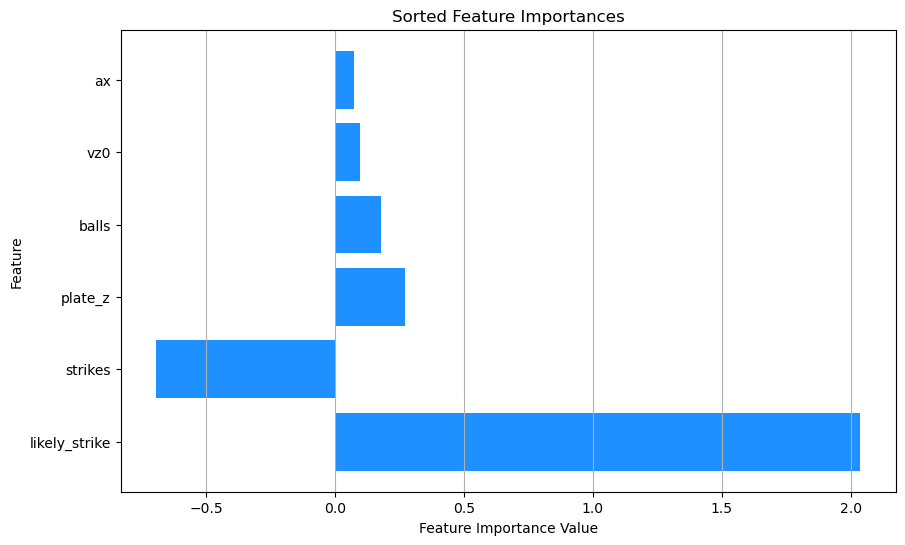

In [1077]:
# Convert the dictionary to a DataFrame
df_sorted_features1 = pd.DataFrame(list(sorted_features1.items()), columns=['Feature', 'Importance'])

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.barh(df_sorted_features1['Feature'], df_sorted_features1['Importance'], color='dodgerblue')
plt.xlabel('Feature Importance Value')
plt.ylabel('Feature')
plt.title('Sorted Feature Importances')
plt.grid(axis='x')

# Show the plot
plt.show()

In [1080]:
# Predict 'is_strike' on the test set
y_pred1 = clf1.predict(x_test_scaled_1)

y_pred1

array([0, 1, 1, ..., 0, 1, 0], dtype=int64)

In [1081]:

# Calculate metrics
accuracy1 = accuracy_score(y_test1, y_pred1)
precision1 = precision_score(y_test1, y_pred1)
recall1 = recall_score(y_test1, y_pred1)
f11 = f1_score(y_test1, y_pred1)
conf_matrix1 = confusion_matrix(y_test1, y_pred1)

In [1082]:

print('Accuracy:', accuracy1)
print('Precision:', precision1)
print('Recall:', recall1)
print('F1:', f11)
print('Confusion Matrix:\n', conf_matrix1)
results_df = pd.DataFrame({'Actual': y_test1, 'Predicted': y_pred1})
results_df.reset_index(drop=True, inplace=True)
x_test_catchers.reset_index(drop=True, inplace=True)
results_df = pd.concat([results_df, x_test_catchers.reset_index(drop=True)], axis=1)

Accuracy: 0.9051376981034035
Precision: 0.9577784503631961
Recall: 0.7054954854531268
F1: 0.8125040118107709
Confusion Matrix:
 [[21542   279]
 [ 2642  6329]]


In [1084]:
# Mask for false negatives
mask_false_negatives_o = (results_df['Actual'] == 1) & (results_df['Predicted'] == 0)
# Mask for false positives
mask_false_positives_o = (results_df['Actual'] == 0) & (results_df['Predicted'] == 1)

# Filter the DataFrame for false negatives and false positives
false_negatives_df_o = result_df[mask_false_negatives_o]
false_positives_df_o = result_df[mask_false_positives_o]

# Concatenate the two to create a DataFrame containing both
framing_o = pd.concat([false_negatives_df_o, false_positives_df_o])# Create a boolean mask for the conditions

In [1087]:
# Create a boolean mask for the conditions
condition_mask = (
    (framing_o['plate_x'].abs() <= .708) & 
    (framing_o['plate_z'] <= framing_o['sz_top']) & 
    (framing_o['plate_z'] >= framing_o['sz_bot'])
)
# Assign 1 or 0 to 'true_strike' based on the conditions calculated before
framing_o['true_strike'] = 0  # Initialize all as 0
framing_o.loc[condition_mask, 'true_strike'] = 1  # Set to 1 where conditions are met
framing_o.loc[framing_o['true_strike'] == 0, 'sum_of_squares'] = ((framing_o['plate_x']**2 + framing_o['plate_z']**2)**.5)
framing_o['normalized_sum_of_squares'] = (framing_o['sum_of_squares'] - framing_o['sum_of_squares'].min()) / (framing_o['sum_of_squares'].max() - framing_o['sum_of_squares'].min())
framing_o['framing_runs'] = framing_o['deltaRE'] - framing_o['normalized_sum_of_squares']